In [55]:
import pandas as pd
from DCC import *
from Utils import *
from Plots import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from collections import defaultdict
from scipy.special import inv_boxcox

init_plotting()

df = pd.read_csv("results/dcc_results.csv")
# df.drop(columns=["dataset"], inplace=True, errors="ignore")
df

type  original_scores  original_scores_std    scores  \
0    classification         0.892254             0.050522  0.900000   
1    classification         0.892254             0.050522  0.872085   
2    classification         0.892254             0.050522  0.897085   
3    classification         0.892254             0.050522  0.881350   
4    classification         0.892254             0.050522  0.866208   
..              ...              ...                  ...       ...   
380      regression         0.822613             0.060846  0.782737   
381      regression         0.822613             0.060846  0.704339   
382      regression         0.822613             0.060846  0.583572   
383      regression         0.822613             0.060846  0.658487   
384      regression         0.822613             0.060846  0.585656   

     scores_std  dcc_pearson  dcc_spearman  dcc_kendall    dcc_mi    dcc_js  \
0      0.041102     0.978022      1.000000     1.000000  1.000000  1.000000   
1      0.043611     0.560440      0.692308     0.802198  0.857143  0.846154   
2      0.042266     0.582418      0.626374     0.747253  0.791209  0.736264   
3      0.053609     0.472527      0.670330     0.769231  0.890110  0.692308   
4      0.064875     0.571429      0.692308     0.824176  0.857143  0.747253   
..          ...          ...           ...          ...       ...       ...   
380    0.052271     0.933333      0.876190     0.971429  0.780952  1.000000   
381    0.077230     0.295238      0.376190     0.457143  0.547619  0.342857   
382    0.091257     0.261905      0.390476     0.423810  0.566667  0.238095   
383    0.085550     0.295238      0.309524     0.404762  0.490476  0.209524   
384    0.127603     0.242857      0.333333     0.390476  0.590476  0.142857   

     ...  corr_cnt_good_pearson  corr_cnt_good_spearman  \
0    ...               0.000000                     0.0   
1    ...               0.000000                     0.0   
2    ...               0.000000                     0.0   
3    ...               0.000000                     0.0   
4    ...               0.000000                     0.0   
..   ...                    ...                     ...   
380  ...               0.263158                     0.0   
381  ...               0.052632                     0.0   
382  ...               0.000000                     0.0   
383  ...               0.105263                     0.0   
384  ...               0.000000                     0.0   

     corr_cnt_good_kendall corr_cnt_good_mi corr_cnt_good_js  \
0                      0.0              0.0         0.416667   
1                      0.0              0.0         0.500000   
2                      0.0              0.0         0.416667   
3                      0.0              0.0         0.416667   
4                      0.0              0.0         0.416667   
..                     ...              ...              ...   
380                    0.0              0.0         0.105263   
381                    0.0              0.0         0.000000   
382                    0.0              0.0         0.000000   
383                    0.0              0.0         0.000000   
384                    0.0              0.0         0.000000   

     corr_cnt_good_wd  corr_cnt_good_xi  corr_cnt_good_dcor  scores_ratio  \
0            0.583333          0.000000            0.000000      1.008682   
1            0.666667          0.000000            0.000000      0.977396   
2            0.750000          0.083333            0.000000      1.005415   
3            0.666667          0.000000            0.000000      0.987779   
4            0.666667          0.000000            0.000000      0.970809   
..                ...               ...                 ...           ...   
380          0.000000          0.000000            0.210526      0.951525   
381          0.000000          0.000000            0.052632      0.856221   
382          0.000000          0.000000   

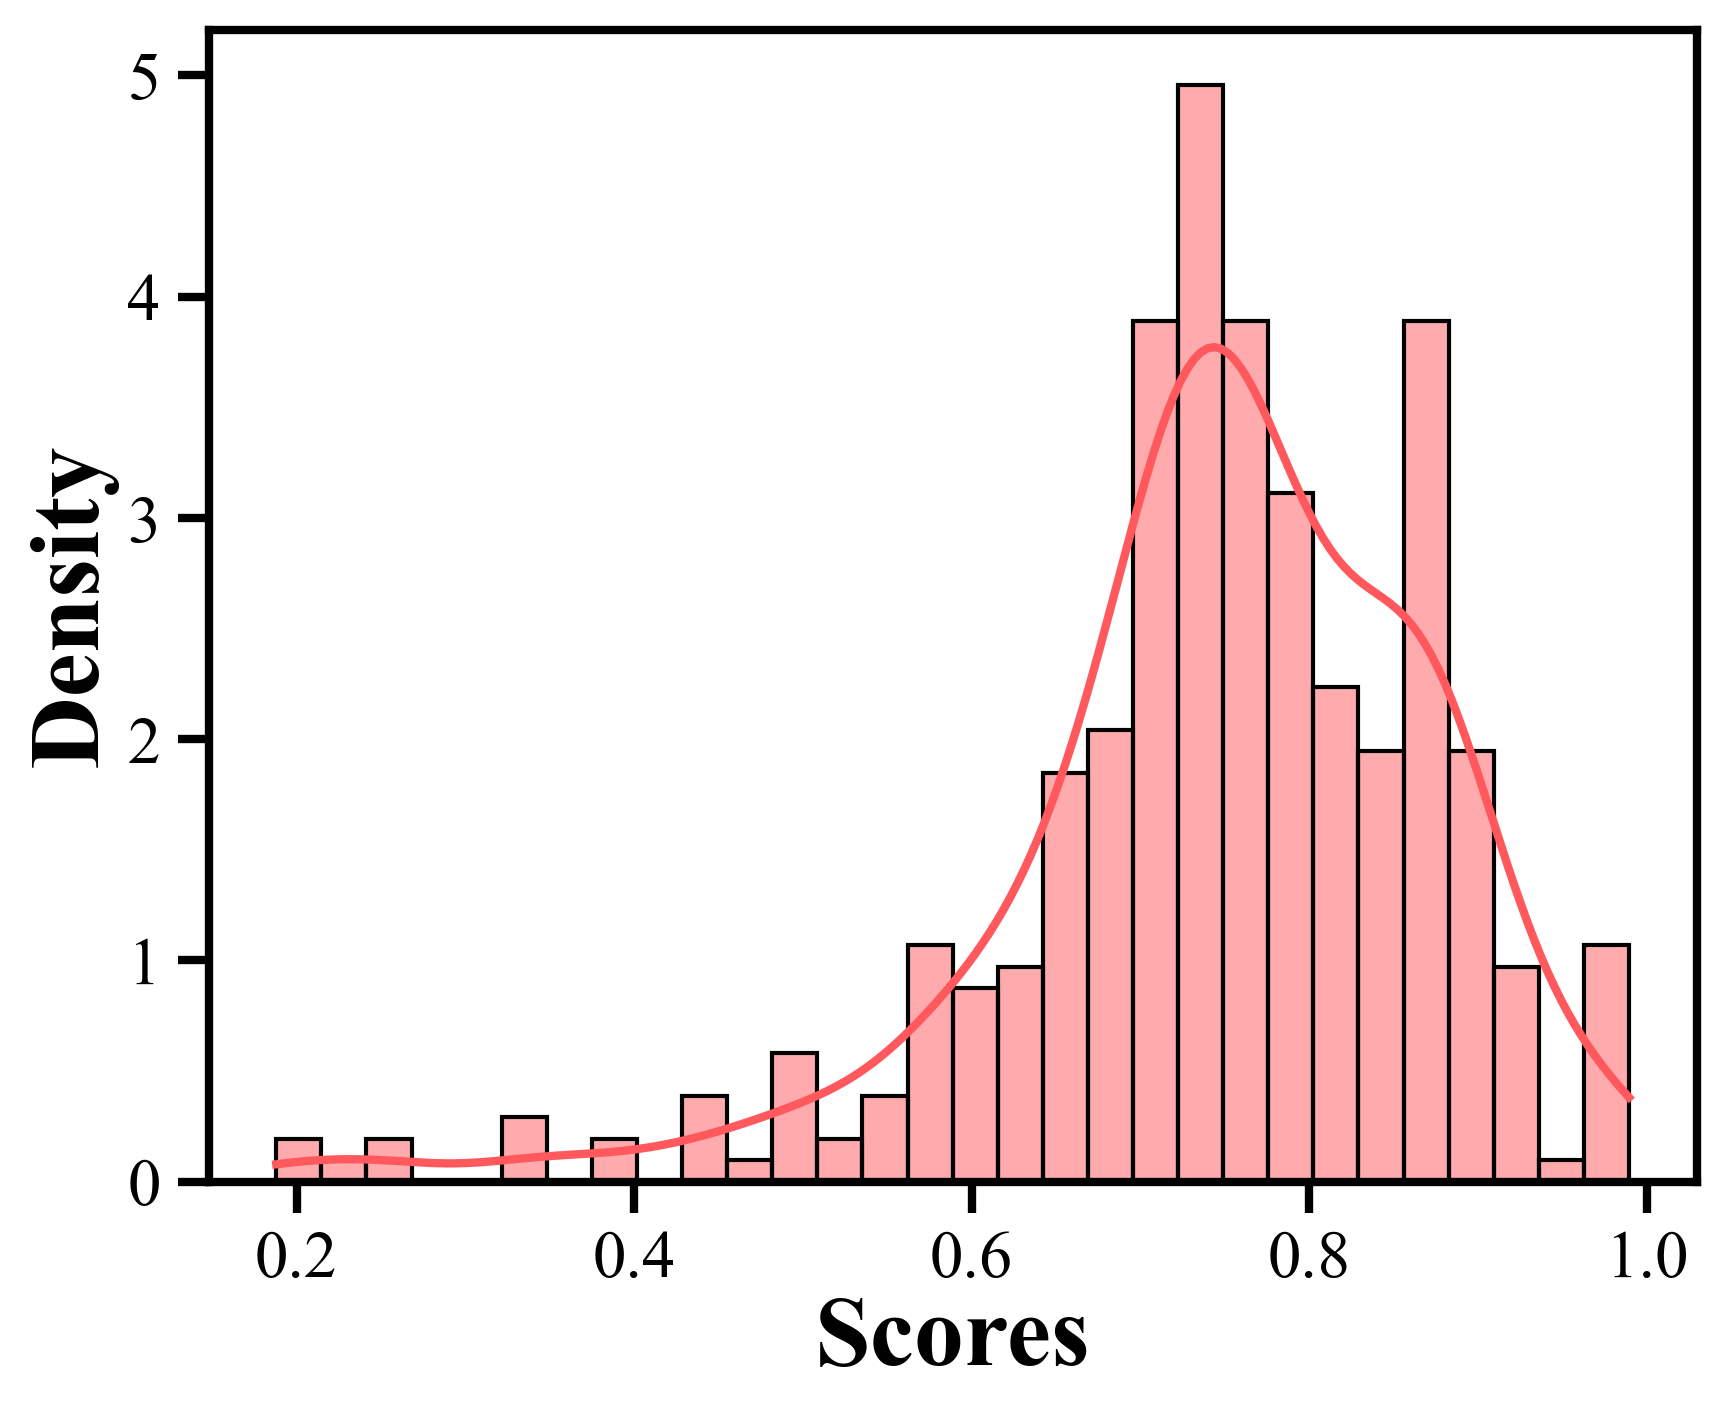

In [56]:
sns.histplot(df, x="scores", kde=True, stat="density", bins=30)
plt.xlabel("Scores")
plt.ylabel("Density")
plt.savefig("plots/scores-histogram.png", dpi=300, bbox_inches="tight")

Lambda for Box-Cox transformation: 2.521146995683322


Text(0, 0.5, 'Density')

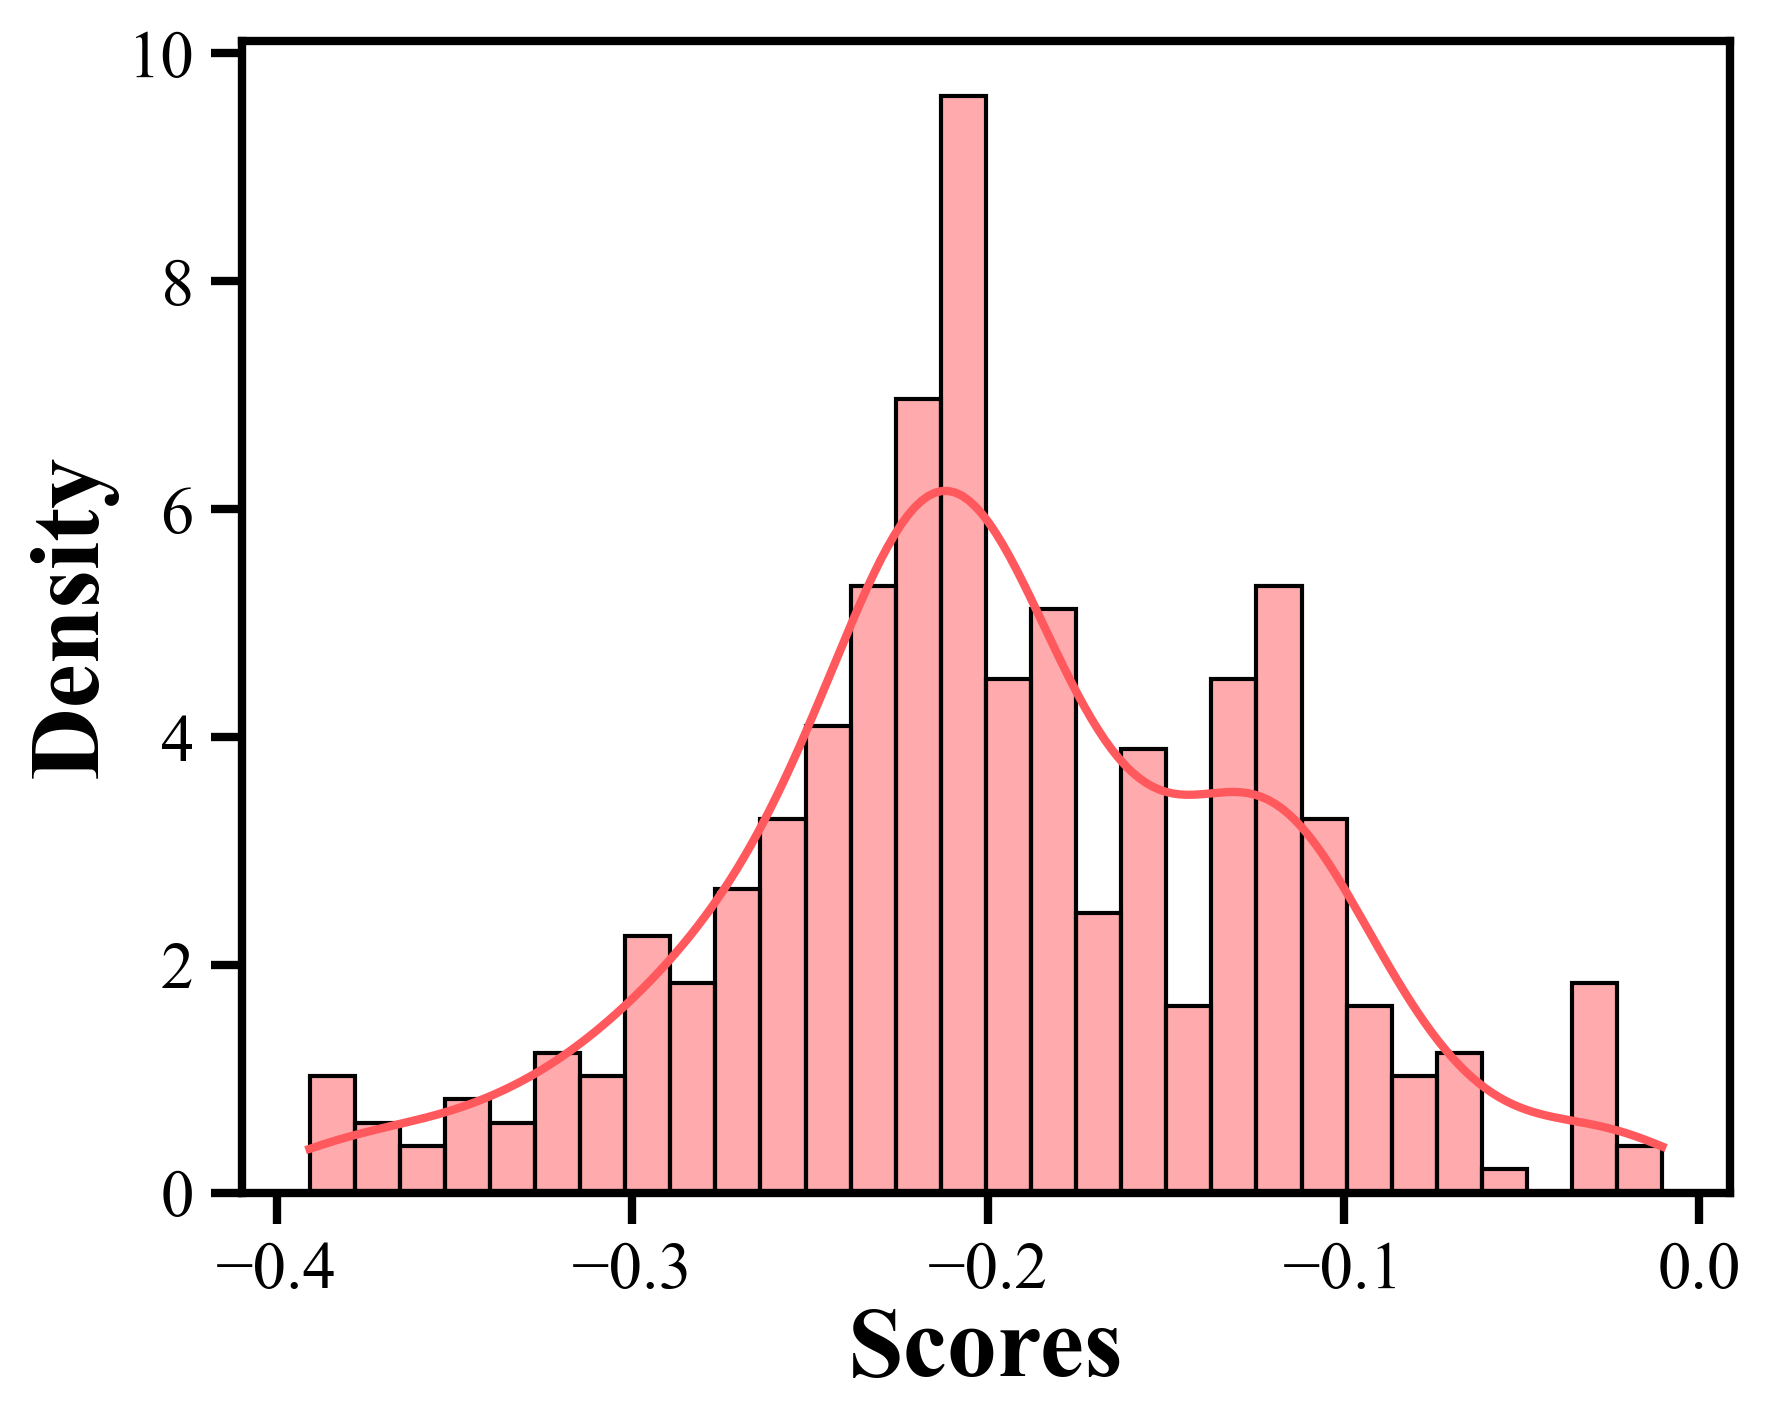

In [57]:
from scipy.stats import boxcox

scores_transformed, lambda_scores = boxcox(df["scores"])
print(f"Lambda for Box-Cox transformation: {lambda_scores}")
df["scores"] = scores_transformed
sns.histplot(df, x="scores", kde=True, stat="density", bins=30)
plt.xlabel("Scores")
plt.ylabel("Density")

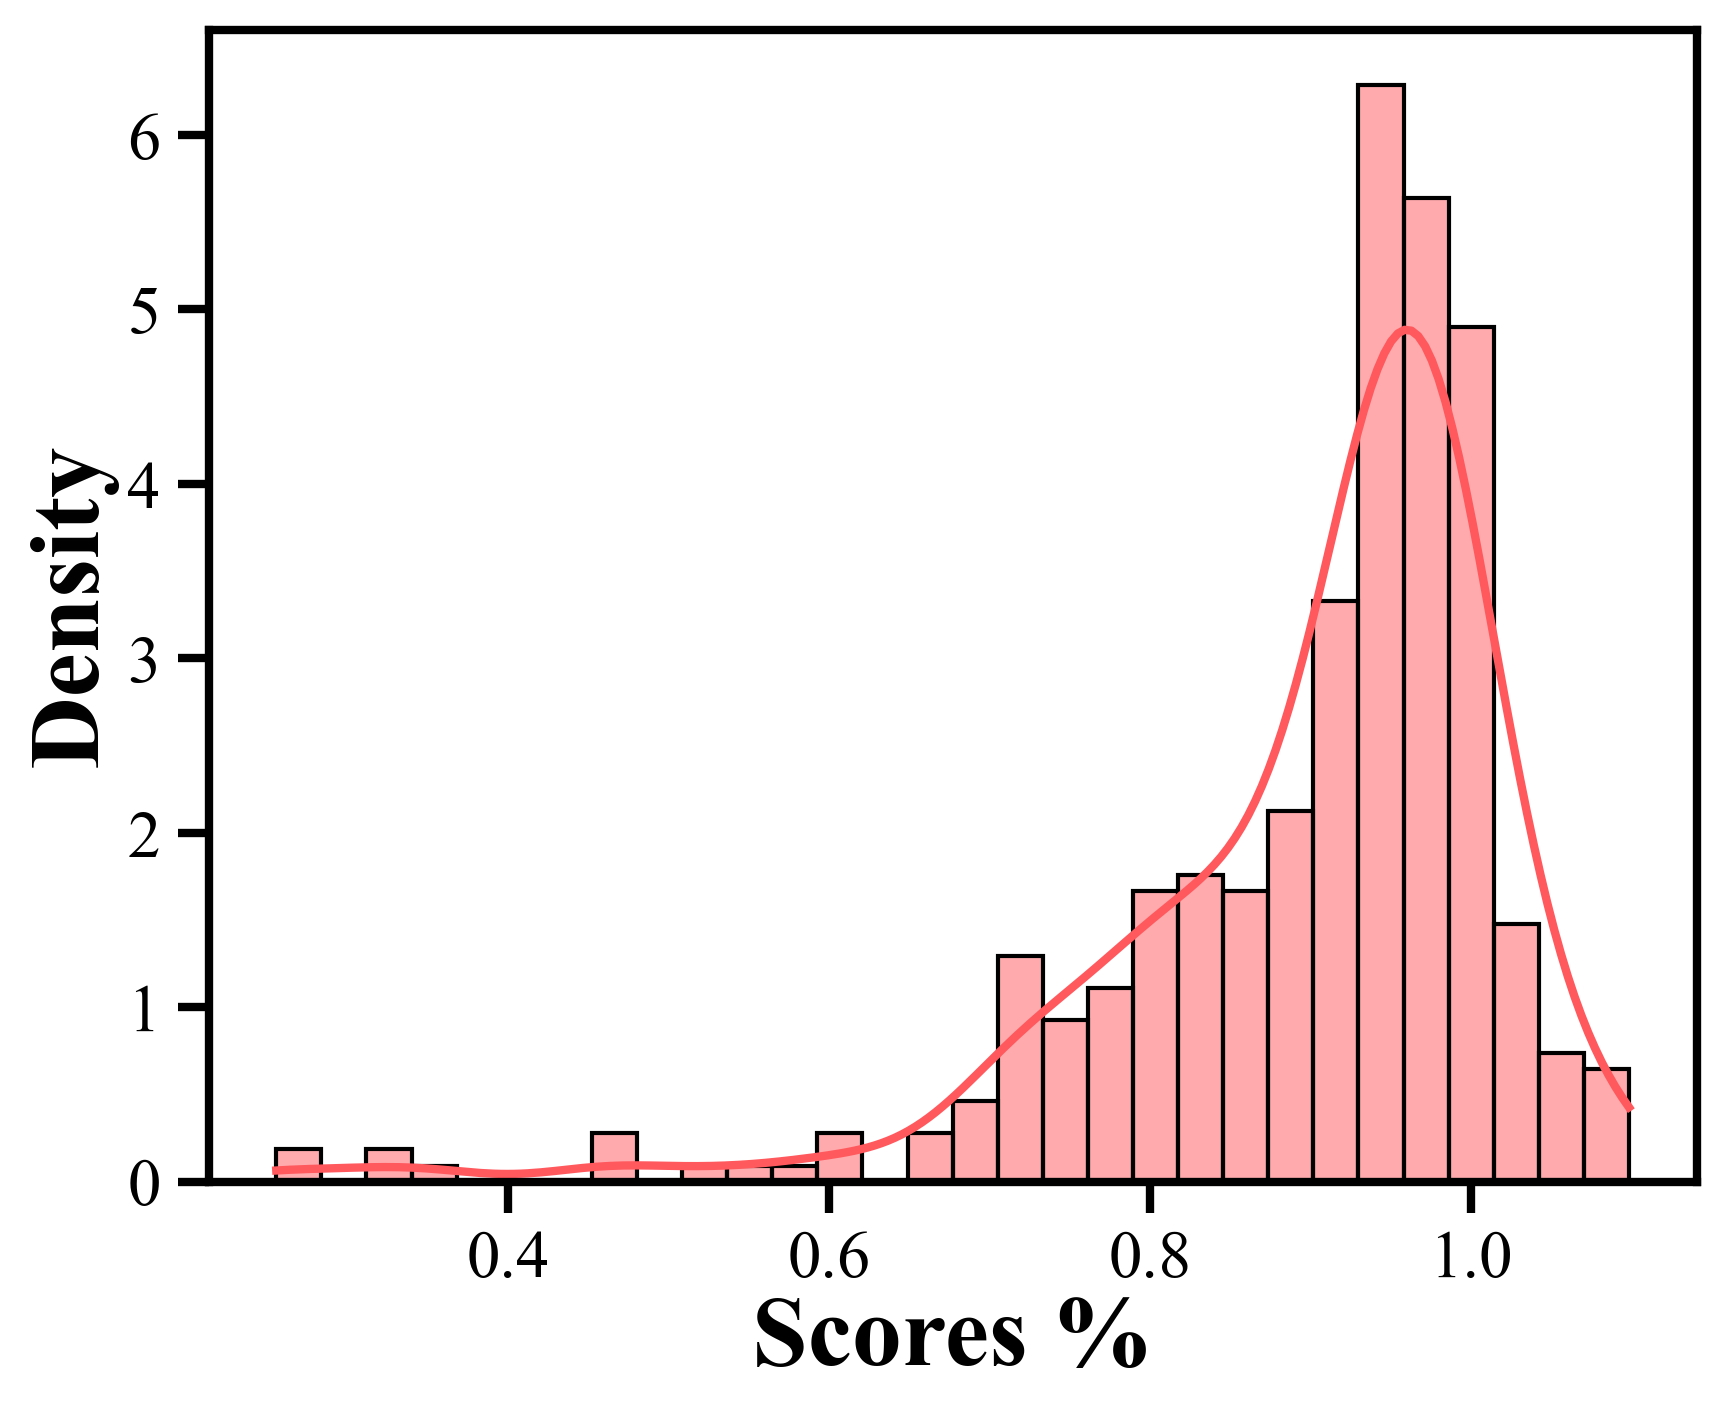

In [58]:
sns.histplot(df, x="scores_ratio", kde=True, stat="density", bins=30)
plt.xlabel("Scores %")
plt.ylabel("Density")
plt.savefig("plots/scores-ratio-histogram.png", dpi=300, bbox_inches="tight")

Lambda for Box-Cox transformation: 4.35796824404266


Text(0, 0.5, 'Density')

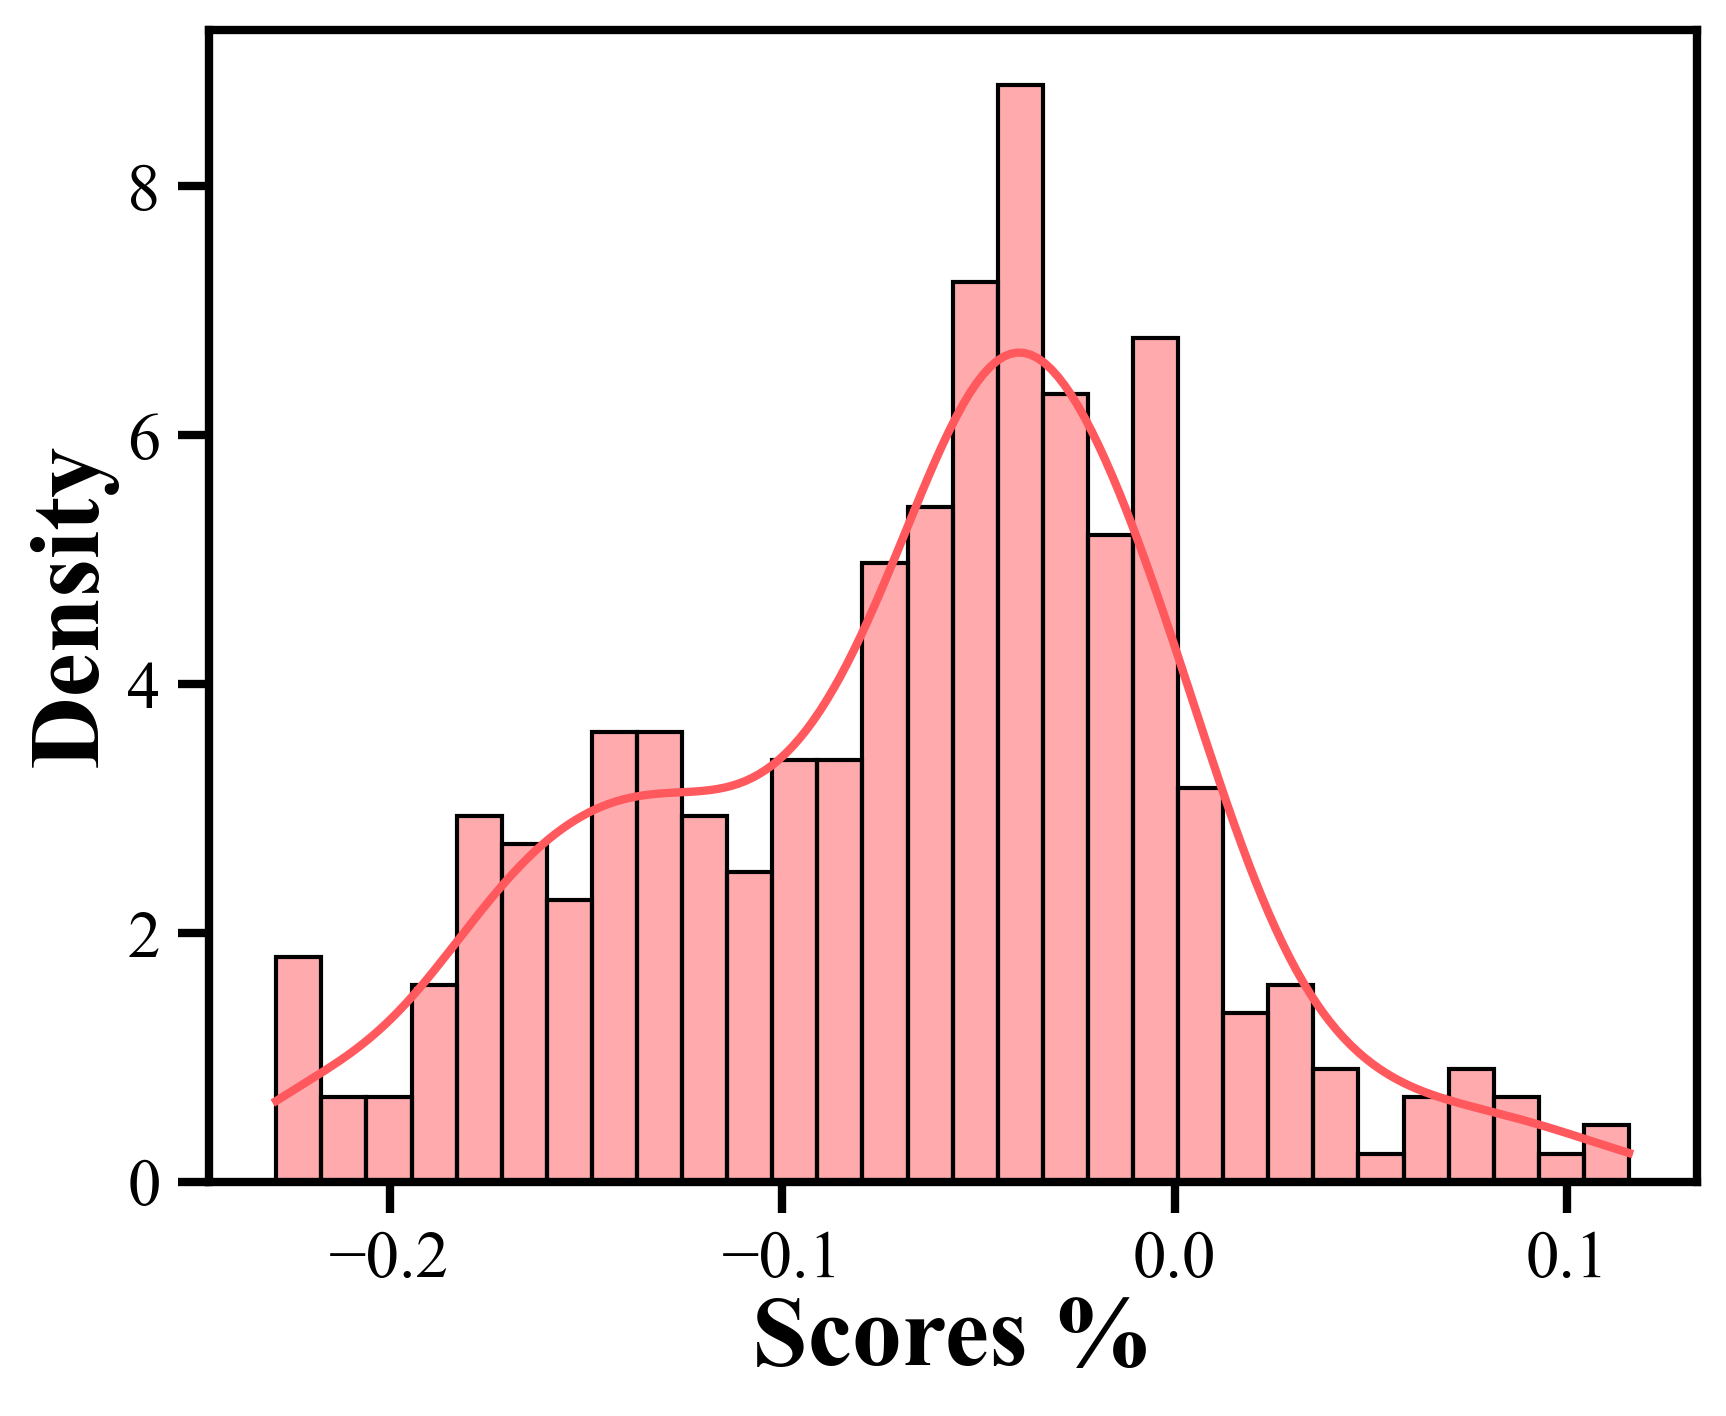

In [59]:
from scipy.stats import boxcox

scores_transformed, lambda_scores_ratio = boxcox(df["scores_ratio"])
print(f"Lambda for Box-Cox transformation: {lambda_scores_ratio}")
df["scores_ratio"] = scores_transformed
sns.histplot(df, x="scores_ratio", kde=True, stat="density", bins=30)
plt.xlabel("Scores %")
plt.ylabel("Density")

In [60]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
)
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from IPython.display import display


def cross_validate_model(model, X, y, cv=3):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)
    return np.mean(scores), np.std(scores)


def exp(df_all):
    print(df_all.shape)
    categorical_cols = df_all.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df_all[col] = le.fit_transform(df_all[col].astype(str))
    fig, ax = plt.subplots(figsize=(32, 32))
    sns.heatmap(
        df_all.corr(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        square=True,
    )
    plt.show()
    all_targets = [
        "original_scores",
        "original_scores_std",
        "scores",
        "scores_std",
        "scores_ratio",
        "scores_std_ratio",
    ]
    X = df_all.drop(columns=all_targets)
    print("Used features:", X.columns.tolist())
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=100, random_state=42
        ),
        "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
        "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
        "Support Vector Regression": SVR(kernel="linear"),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
    }
    results = defaultdict(dict)
    for target in all_targets:
        Y = df_all[target]
        print(f"Evaluating models for target: {target}")
        for model_name, model in models.items():
            mean_score, std_score = cross_validate_model(model, X, Y, cv=3)
            results[target][model_name] = f"{mean_score:.4f} ± {std_score:.4f}"
    results_df = pd.DataFrame(results).T
    display(results_df)

In [61]:
all_cols = [
    "type",
    "original_scores",
    "original_scores_std",
    "scores",
    "scores_std",
    "dcc_pearson",
    "dcc_spearman",
    "dcc_kendall",
    "dcc_mi",
    "dcc_js",
    "dcc_wd",
    "dcc_xi",
    "dcc_dcor",
    "perturbation_type",
    "dataset",
    "ptb_ratio",
    "corr_max_pearson",
    "corr_max_spearman",
    "corr_max_kendall",
    "corr_max_mi",
    "corr_max_js",
    "corr_max_wd",
    "corr_max_xi",
    "corr_max_dcor",
    "corr_cnt_good_pearson",
    "corr_cnt_good_spearman",
    "corr_cnt_good_kendall",
    "corr_cnt_good_mi",
    "corr_cnt_good_js",
    "corr_cnt_good_wd",
    "corr_cnt_good_xi",
    "corr_cnt_good_dcor",
    "scores_ratio",
    "scores_std_ratio",
]

In [62]:
df_all = df.copy()
df_all.drop(columns=["dataset"], inplace=True, errors="ignore")
categorical_cols = df_all.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))
# df_all = df.select_dtypes(include=[np.number])
fig, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(
    df_all.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar=False,
)

<Axes: >

In [63]:
X_cols = df.columns.drop(
    [
        "original_scores",
        "original_scores_std",
        "scores",
        "scores_std",
        "scores_ratio",
        "scores_std_ratio",
    ]
).tolist()
X_cols

['type',
 'dcc_pearson',
 'dcc_spearman',
 'dcc_kendall',
 'dcc_mi',
 'dcc_js',
 'dcc_wd',
 'dcc_xi',
 'dcc_dcor',
 'perturbation_type',
 'dataset',
 'ptb_ratio',
 'corr_max_pearson',
 'corr_max_spearman',
 'corr_max_kendall',
 'corr_max_mi',
 'corr_max_js',
 'corr_max_wd',
 'corr_max_xi',
 'corr_max_dcor',
 'corr_cnt_good_pearson',
 'corr_cnt_good_spearman',
 'corr_cnt_good_kendall',
 'corr_cnt_good_mi',
 'corr_cnt_good_js',
 'corr_cnt_good_wd',
 'corr_cnt_good_xi',
 'corr_cnt_good_dcor']

In [64]:
X_cols = [
    "type",
    "dcc_pearson",
    # "dcc_spearman",
    # "dcc_kendall",
    "dcc_mi",
    "dcc_js",
    # "dcc_wd",
    # "dcc_xi",
    # "dcc_dcor",
    # "perturbation_type",
    # "ptb_ratio",
    "corr_max_pearson",
    # "corr_max_spearman",
    # "corr_max_kendall",
    "corr_max_mi",
    "corr_max_js",
    # "corr_max_xi",
    # "corr_max_dcor",
]

In [65]:
X_cols = [
    "corr_max_dcor",
    "corr_max_js",
    "corr_max_pearson",
    "dcc_dcor",
    "dcc_js",
    "dcc_pearson",
]

In [66]:
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.scatterplot(data=df, x="dcc_mi", y="scores_ratio", hue="dataset", s=100)

# plt.xlabel(r"$DCC_{MI}$")
# plt.ylabel("Scores Ratio")
# plt.legend(
#     title="Dataset",
#     fontsize=14,
#     title_fontsize=16,
# )

In [67]:
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.scatterplot(data=df, x="corr_max_js", y="scores", hue="dataset", s=100)

# plt.xlabel(r"$Max Corr_{JS}$")
# plt.ylabel("Scores")
# plt.legend(
#     title="Dataset",
#     fontsize=14,
#     title_fontsize=16,
# )

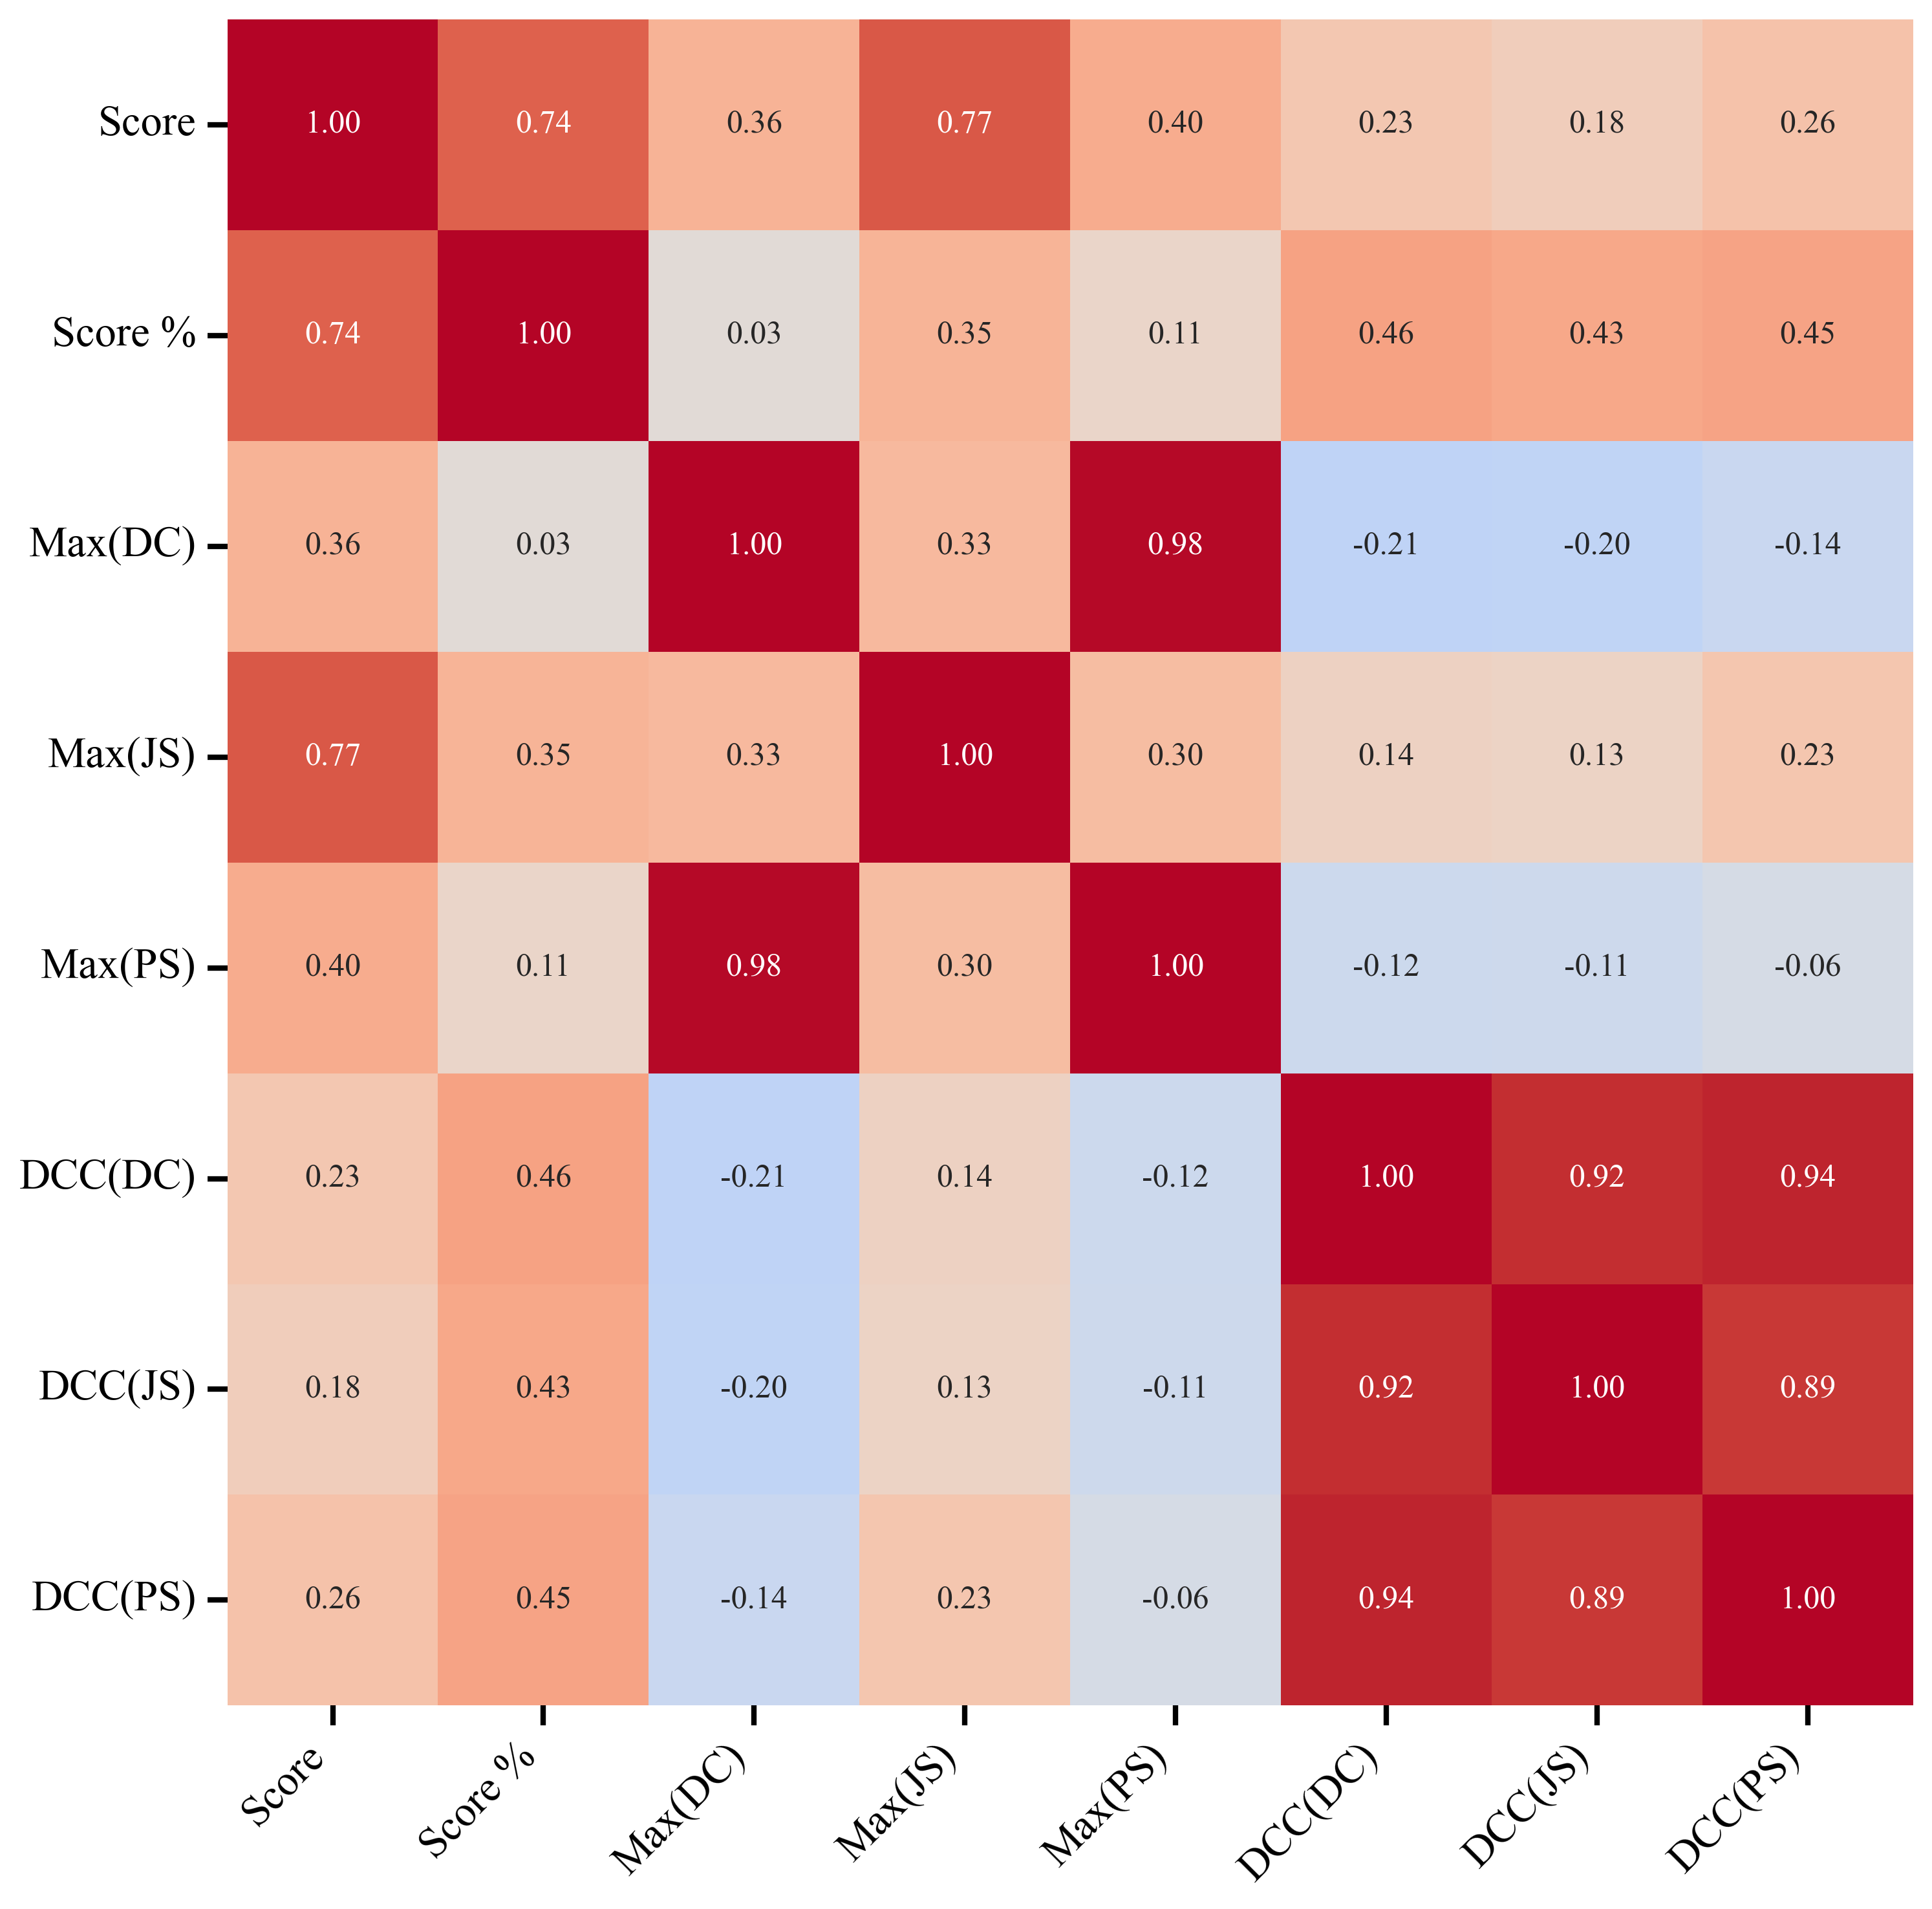

In [68]:
select_cols = (
    ["scores", "scores_ratio"] + X_cols 
)
# select_cols = [
#     "scores",
#     "scores_ratio",
#     "type",
#     "perturbation_type",
#     "ptb_ratio",
#     "original_scores",
#     "original_scores_std",
#     "dcc_pearson",
#     "dcc_spearman",
#     "dcc_kendall",
#     "dcc_mi",
#     "dcc_js",
#     "dcc_wd",
#     "dcc_xi",
#     "dcc_dcor",
#     "corr_max_pearson",
#     "corr_max_spearman",
#     "corr_max_kendall",
#     "corr_max_mi",
#     "corr_max_js",
#     "corr_max_wd",
#     "corr_max_xi",
#     "corr_max_dcor",
# ]
exp_df = df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))

plt.figure(figsize=(12, 10))
# custom_labels = [
#     "Score",
#     "Score %",
#     "Type",
#     # "Ptb Type",
#     # "Ptb Ratio",
#     # r"Scores$_{ori}$",
#     # r"Scores-Std$_{ori}$",
#     r"DCC(PS)",
#     # r"DCC$_{SP}$",
#     # r"DCC$_{KD}$",
#     r"DCC(MI)",
#     r"DCC(JS)",
#     # r"DCC$_{WD}$",
#     # r"DCC$_{XI}$",
#     # r"DCC$_{DC}$",
#     r"Max(PS)",
#     # r"MaxCorr$_{SP}$",
#     # r"MaxCorr$_{KD}$",
#     r"Max(MI)",
#     r"Max(JS)",
#     # r"MaxCorr$_{WD}$",
#     # r"MaxCorr$_{XI}$",
#     # r"MaxCorr$_{DC}$",
# ]
custom_lables_dict = {
    "scores": "Score",
    "scores_ratio": "Score %",
    "type": "Type",
    "perturbation_type": "Ptb Type",
    "ptb_ratio": "Ptb Ratio",
    "original_scores": r"Scores$_{ori}$",
    "original_scores_std": r"Scores-Std$_{ori}$",
    "dcc_pearson": r"DCC(PS)",
    "dcc_spearman": r"DCC(SP)",
    "dcc_kendall": r"DCC(KD)",
    "dcc_mi": r"DCC(MI)",
    "dcc_js": r"DCC(JS)",
    "dcc_wd": r"DCC(WD)",
    "dcc_xi": r"DCC(XI)",
    "dcc_dcor": r"DCC(DC)",
    "corr_max_pearson": r"Max(PS)",
    "corr_max_spearman": r"Max(SP)",
    "corr_max_kendall": r"Max(KD)",
    "corr_max_mi": r"Max(MI)",
    "corr_max_js": r"Max(JS)",
    "corr_max_wd": r"Max(WD)",
    "corr_max_xi": r"Max(XI)",
    "corr_max_dcor": r"Max(DC)",
}

sns.heatmap(
    exp_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    xticklabels=[custom_lables_dict.get(col, col) for col in exp_df.columns],
    yticklabels=[custom_lables_dict.get(col, col) for col in exp_df.columns],
    cbar=False,
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/scores_heatmap.png", dpi=300, bbox_inches="tight")

Used cols ['scores_ratio', 'corr_max_dcor', 'corr_max_js', 'corr_max_pearson', 'dcc_dcor', 'dcc_js', 'dcc_pearson']
R2 Scores: [0.8106608017203585, 0.7365842077389742, 0.7080581240668302, 0.6595881736444122, 0.8744211357356755]
Adjusted R2 Scores: [0.7944317275821035, 0.7140057112594577, 0.68303453470113, 0.6304100170996476, 0.8636572330844476]


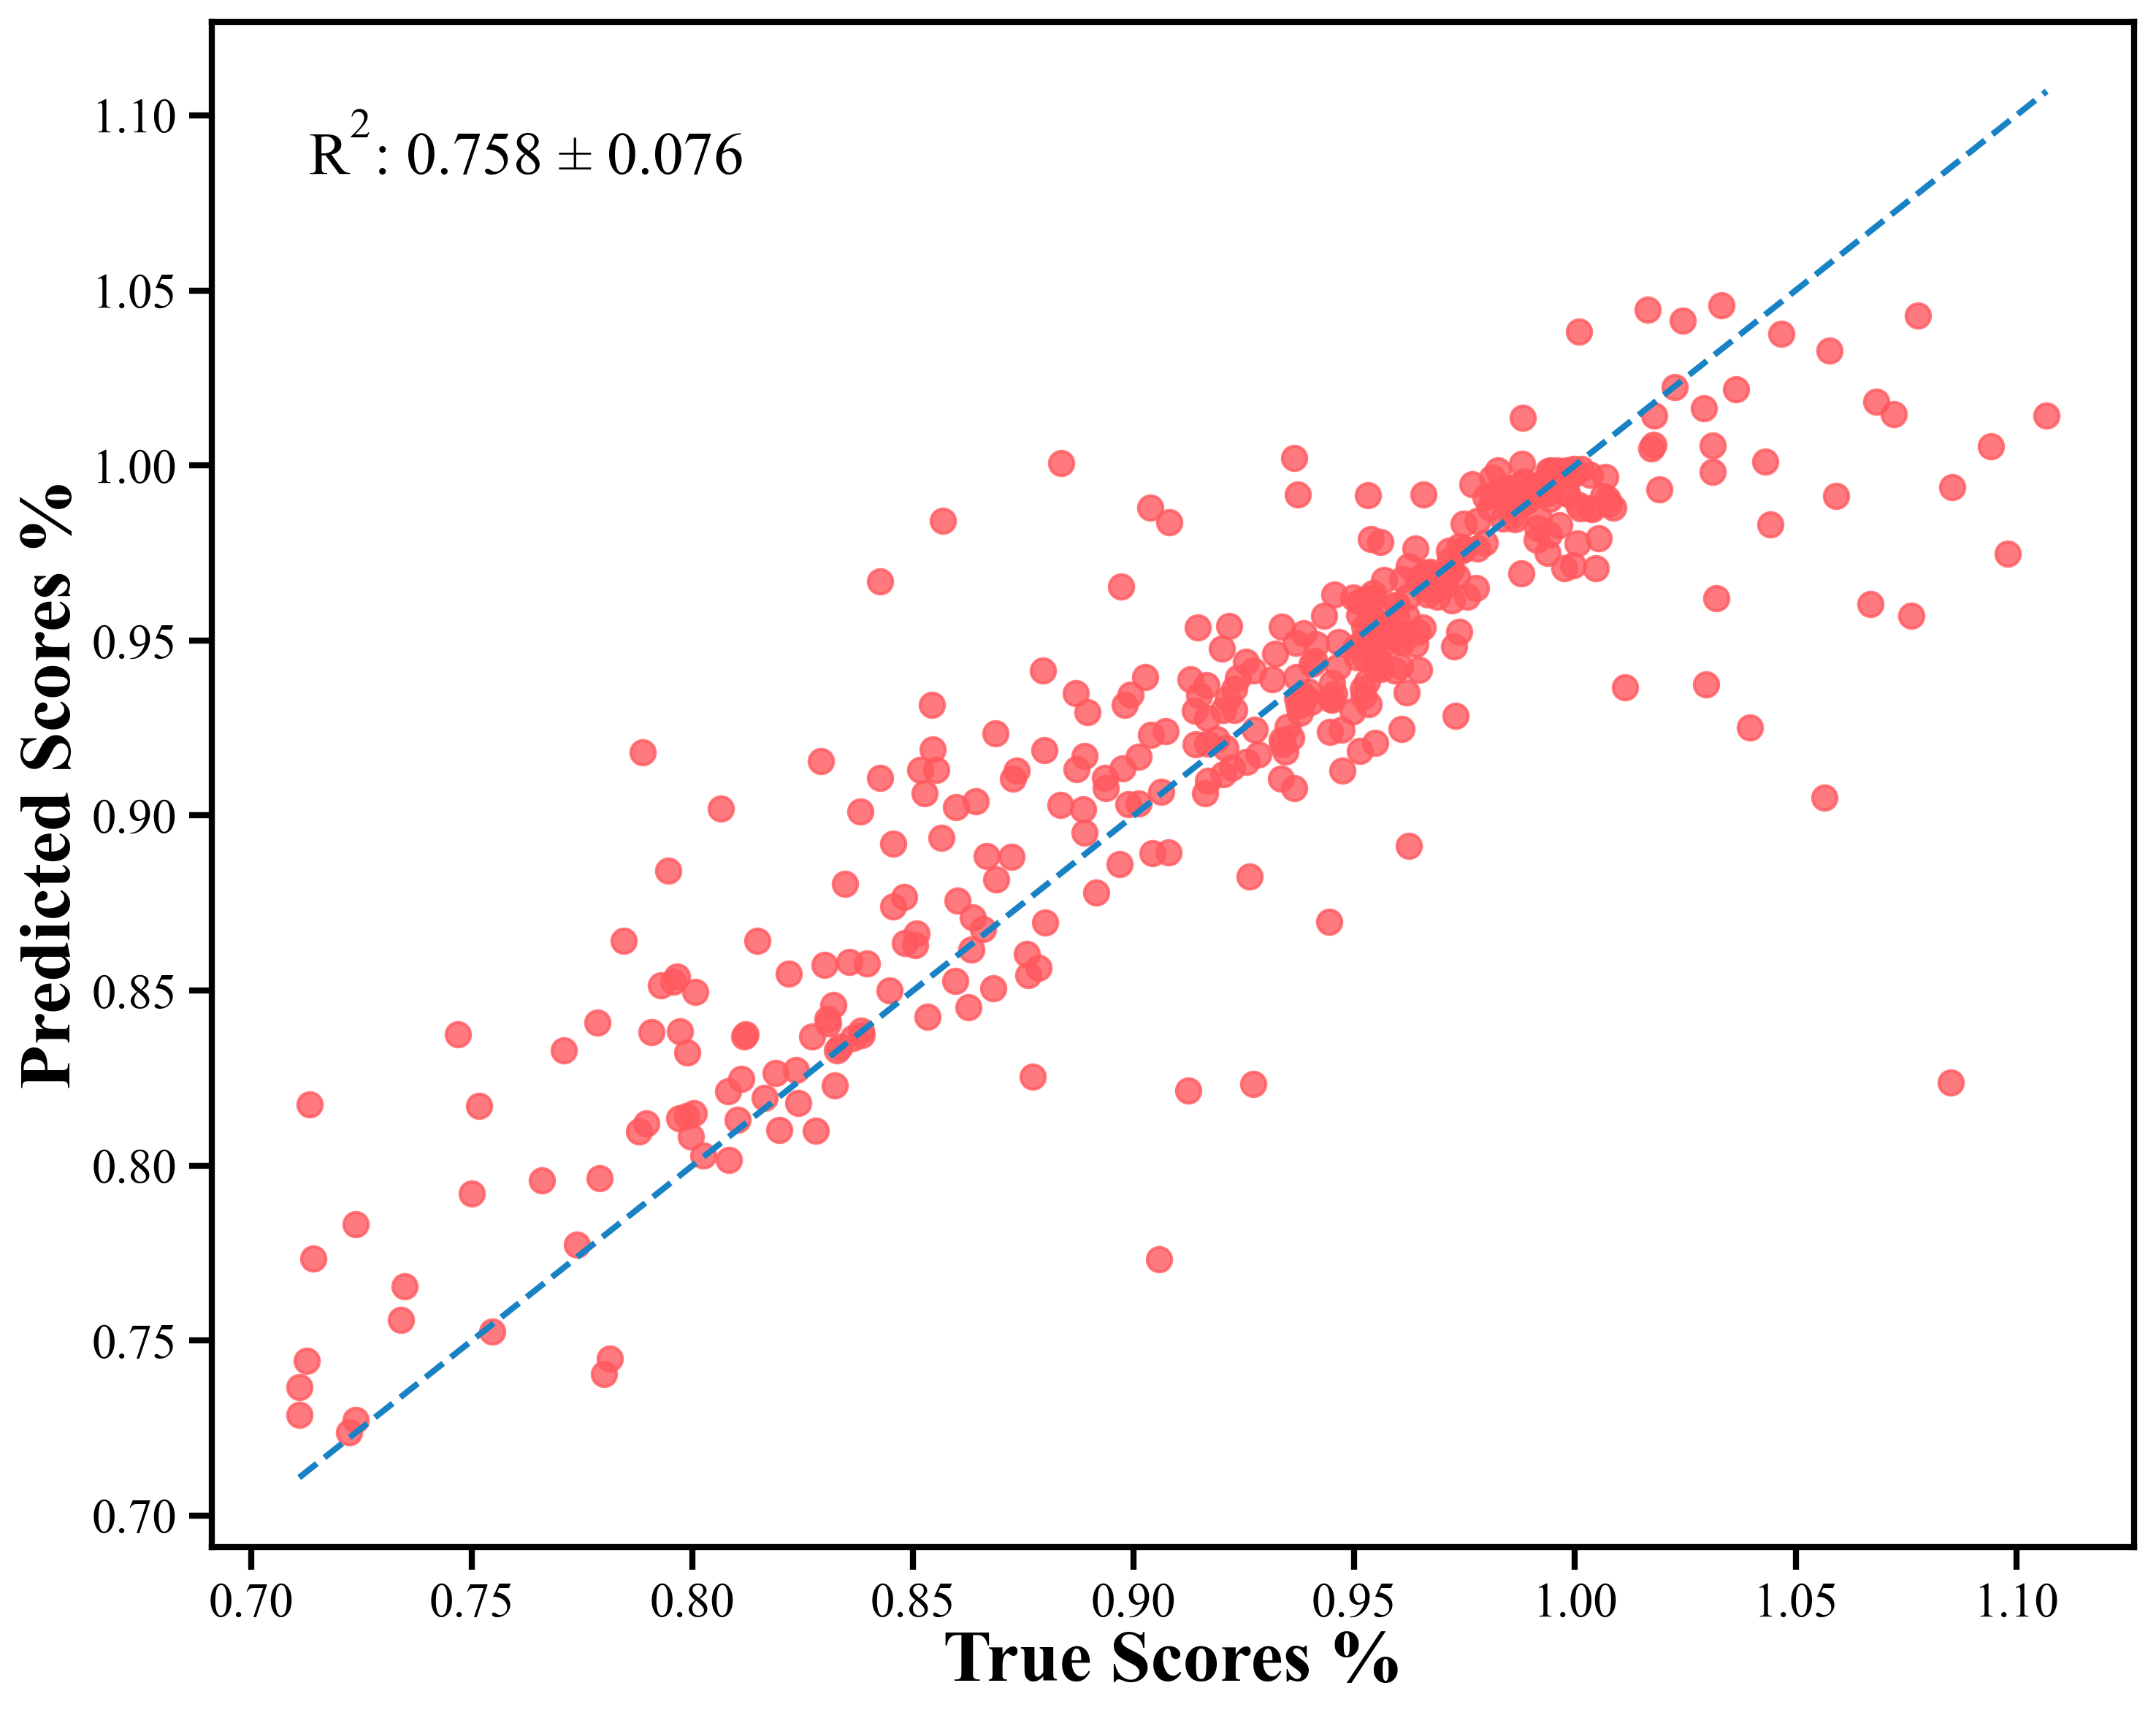

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def adjusted_r2_score(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

# ========== 数据处理 ==========
select_cols = ["scores_ratio"] + X_cols
exp_df = df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))

print("Used cols", exp_df.columns.tolist())

# ========== 模型与KFold ==========
model = RandomForestRegressor(n_estimators=500, random_state=42)
X = exp_df.drop(columns=["scores_ratio"])
y = exp_df["scores_ratio"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_trues = []
all_preds = []
r2_scores = []
adjusted_r2_scores = []

# 保存SHAP数据
shap_values_all = []
X_all = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    all_trues.extend(y_test.tolist())
    all_preds.extend(preds.tolist())

    # 反变换预测值
    y_test = inv_boxcox(y_test, lambda_scores_ratio)
    preds = inv_boxcox(preds, lambda_scores_ratio)

    r2 = r2_score(y_test, preds)
    adjusted_r2 = adjusted_r2_score(y_test, preds, X_test.shape[1])
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2)

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap_values_all.append(shap_values)
    X_all.append(X_test)

# ========== 汇总结果 ==========
print(f"R2 Scores: {r2_scores}")
print(f"Adjusted R2 Scores: {adjusted_r2_scores}")



# 反变换预测值
all_preds = inv_boxcox(np.array(all_preds), lambda_scores)
all_trues = inv_boxcox(np.array(all_trues), lambda_scores)

# ========== R2 散点图 ==========
plt.figure(figsize=(10, 8))
plt.plot(
    [min(all_trues), max(all_trues)],
    [min(all_trues), max(all_trues)],
    color="#1982C4",
    linestyle="--",
)
plt.scatter(all_trues, all_preds, alpha=0.8)
plt.xlabel("True Scores %")
plt.ylabel("Predicted Scores %")
plt.text(
    0.05,
    0.90,
    f"$R^2$: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}",
    transform=plt.gca().transAxes,
    fontsize=20,
)
plt.tight_layout()
plt.savefig("plots/scores_ratio_r2_scatter.png", dpi=300, bbox_inches="tight")
plt.show()


Default feature order: ['corr_max_js', 'corr_max_pearson', 'dcc_pearson', 'dcc_js', 'corr_max_dcor', 'dcc_dcor']


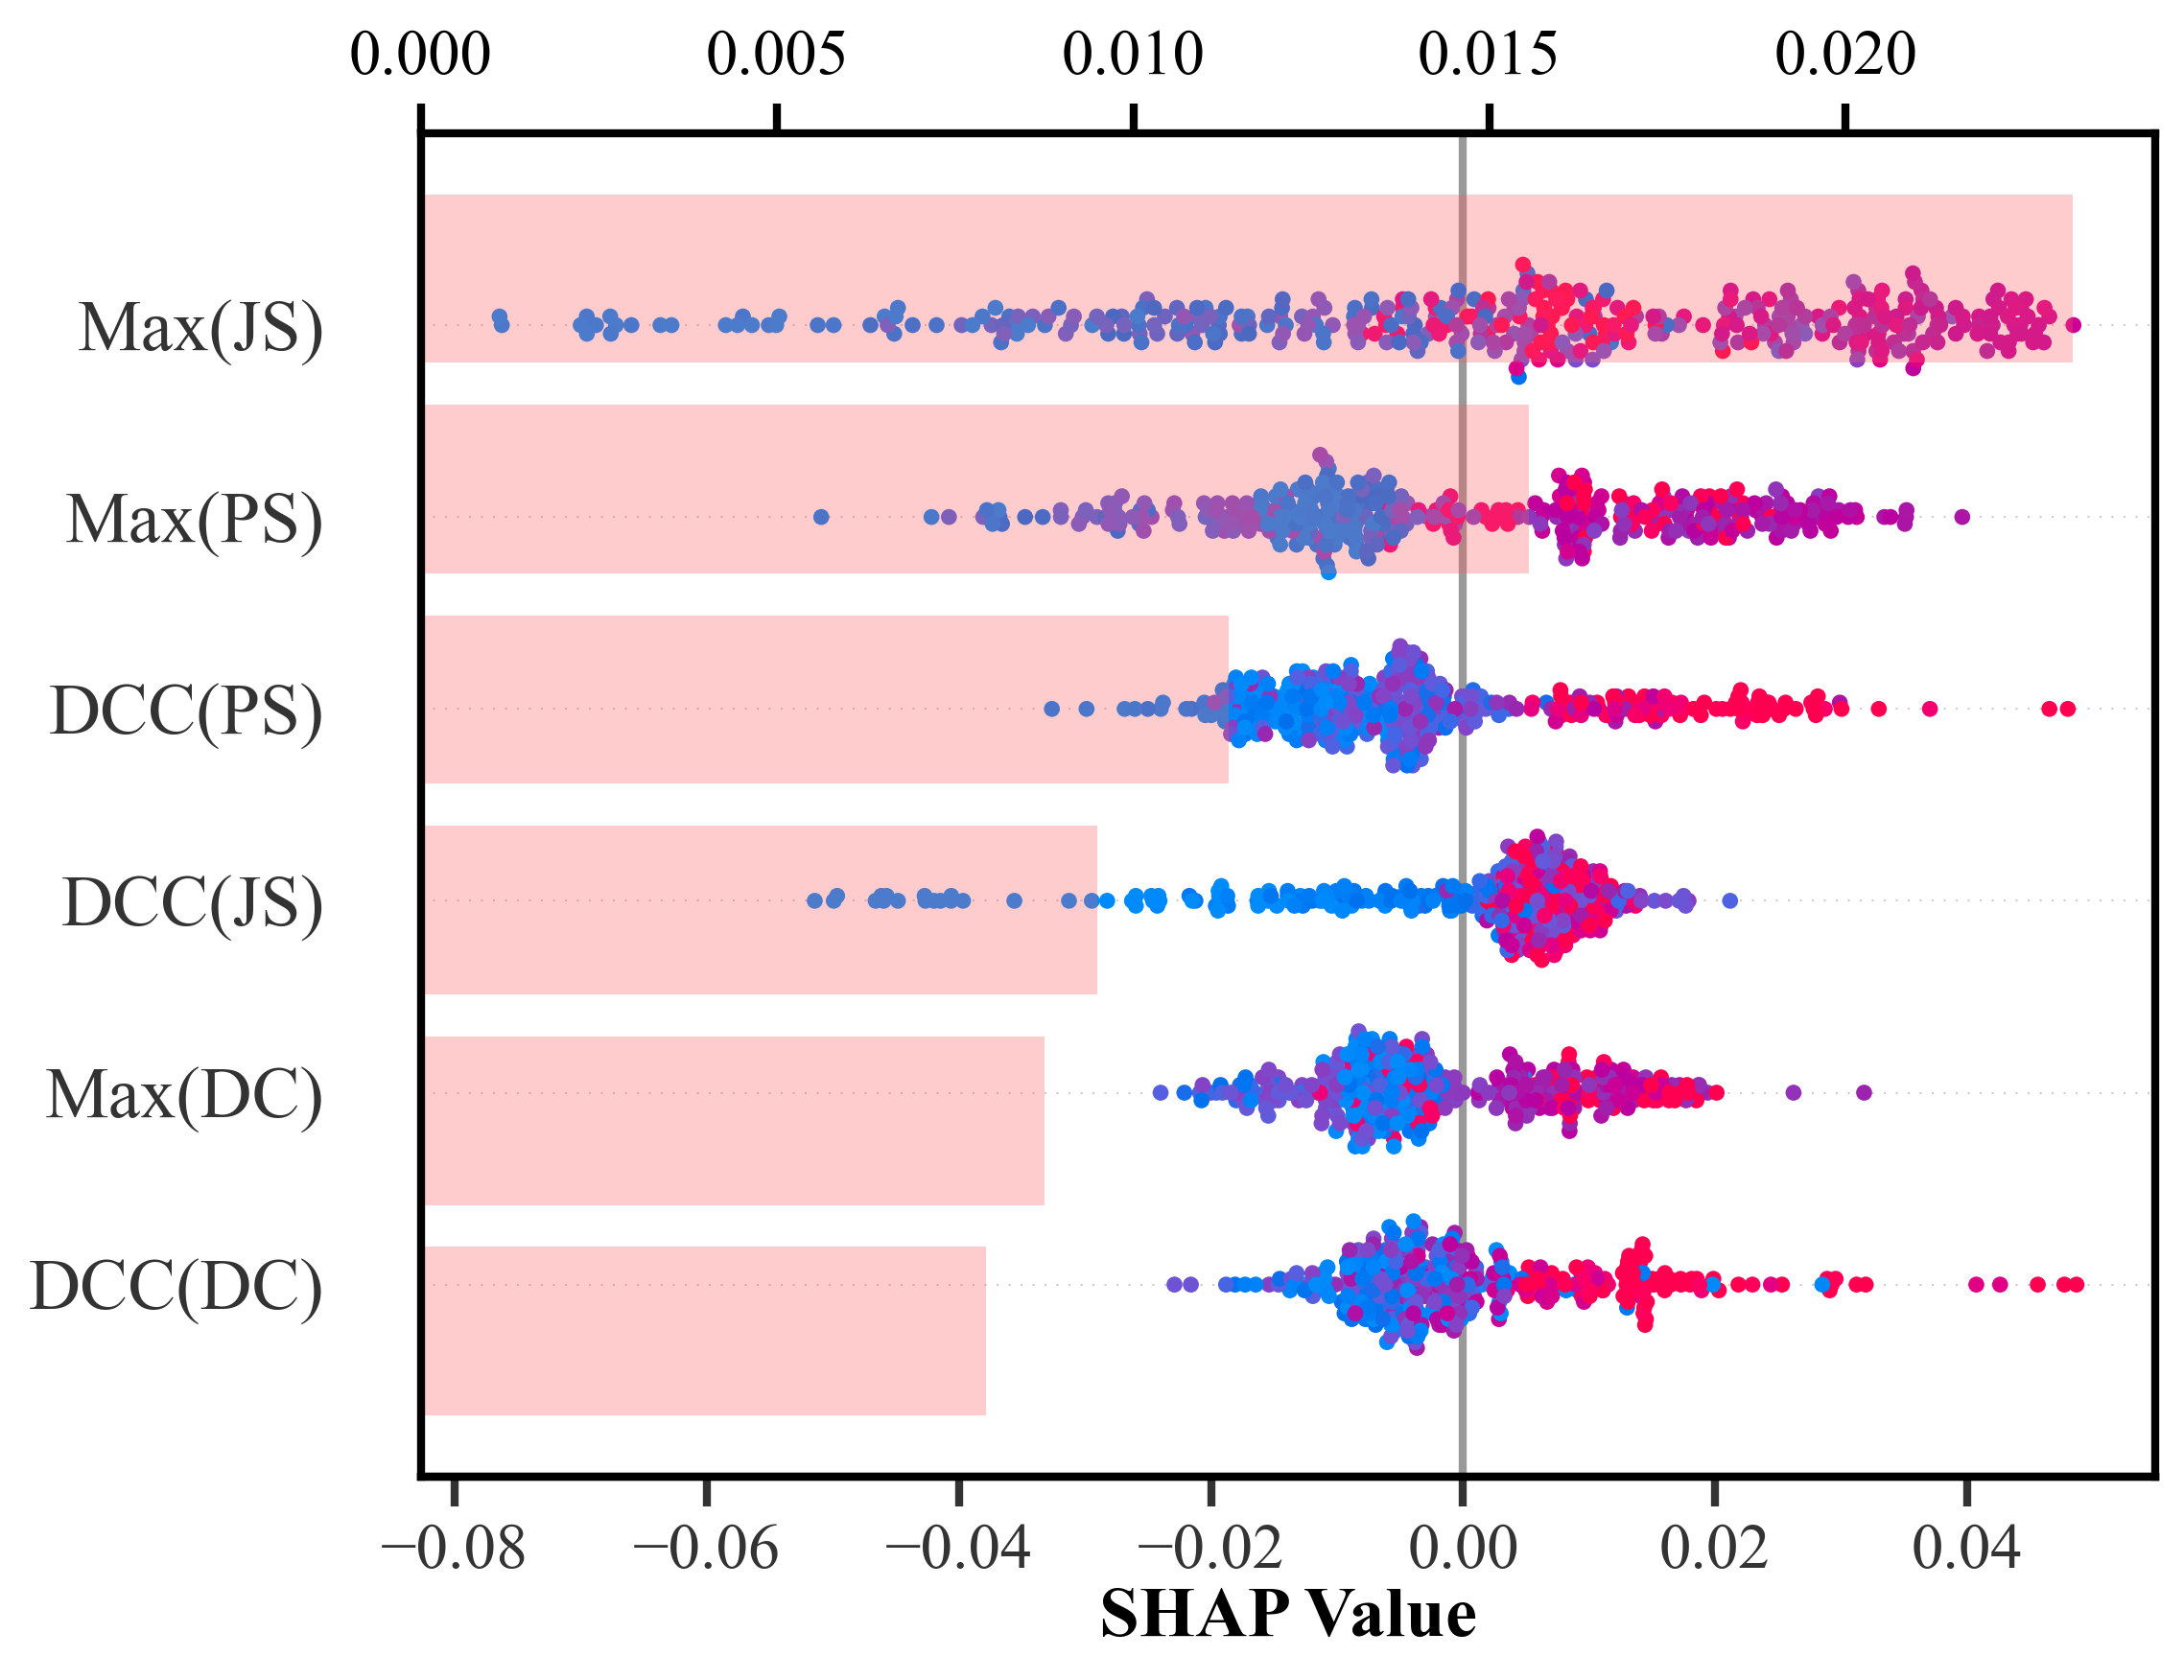

In [70]:
# ========== SHAP 合并画图 ==========
# 合并所有折的 SHAP 值和输入
shap_values_concat = np.concatenate(shap_values_all, axis=0)
X_concat = pd.concat(X_all, axis=0)

# 计算默认特征重要性顺序（用于排序）
mean_abs_shap = np.abs(shap_values_concat).mean(axis=0)
sort_idx = np.argsort(mean_abs_shap)[::-1]
feature_names = X_concat.columns[sort_idx].tolist()
print("Default feature order:", feature_names)

# 替换为自定义名称
custom_names = [custom_lables_dict.get(col, col) for col in feature_names]

custom_names = list(reversed(custom_names))

# 创建画布
fig, ax1 = plt.subplots(figsize=(8, 6))

# ===== 绘制 SHAP 点图 =====
shap.summary_plot(
    shap_values_concat, 
    X_concat, 
    show=False, 
    max_display=len(custom_names), 
    feature_names=custom_names,
    color_bar=False,
)
plt.gca().tick_params(axis='x', labelsize=16)
plt.gca().set_xlabel("SHAP Value", fontsize=18)
plt.gca().set_yticklabels(custom_names, fontsize=18)
# ===== 绘制 SHAP 条形图 =====
ax2 = ax1.twiny()
bar_heights = mean_abs_shap[sort_idx][::-1]
ax2.barh(
    np.arange(len(feature_names)),
    bar_heights,
    alpha=0.3,
)

# 调整布局
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.savefig("plots/scores_ratio_shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()

Used cols ['scores', 'corr_max_dcor', 'corr_max_js', 'corr_max_pearson', 'dcc_dcor', 'dcc_js', 'dcc_pearson']
Features used: ['corr_max_dcor', 'corr_max_js', 'corr_max_pearson', 'dcc_dcor', 'dcc_js', 'dcc_pearson']
R2 Scores: [0.8712887287877944, 0.8769567115716205, 0.853620998488859, 0.7907893962648503, 0.9327154050040807]
Adjusted R2 Scores: [0.8602563341124625, 0.8664101439920451, 0.8410742269307612, 0.7728570588018375, 0.9269481540044304]
Lambda used for inverse Box-Cox transformation: 2.521146995683322


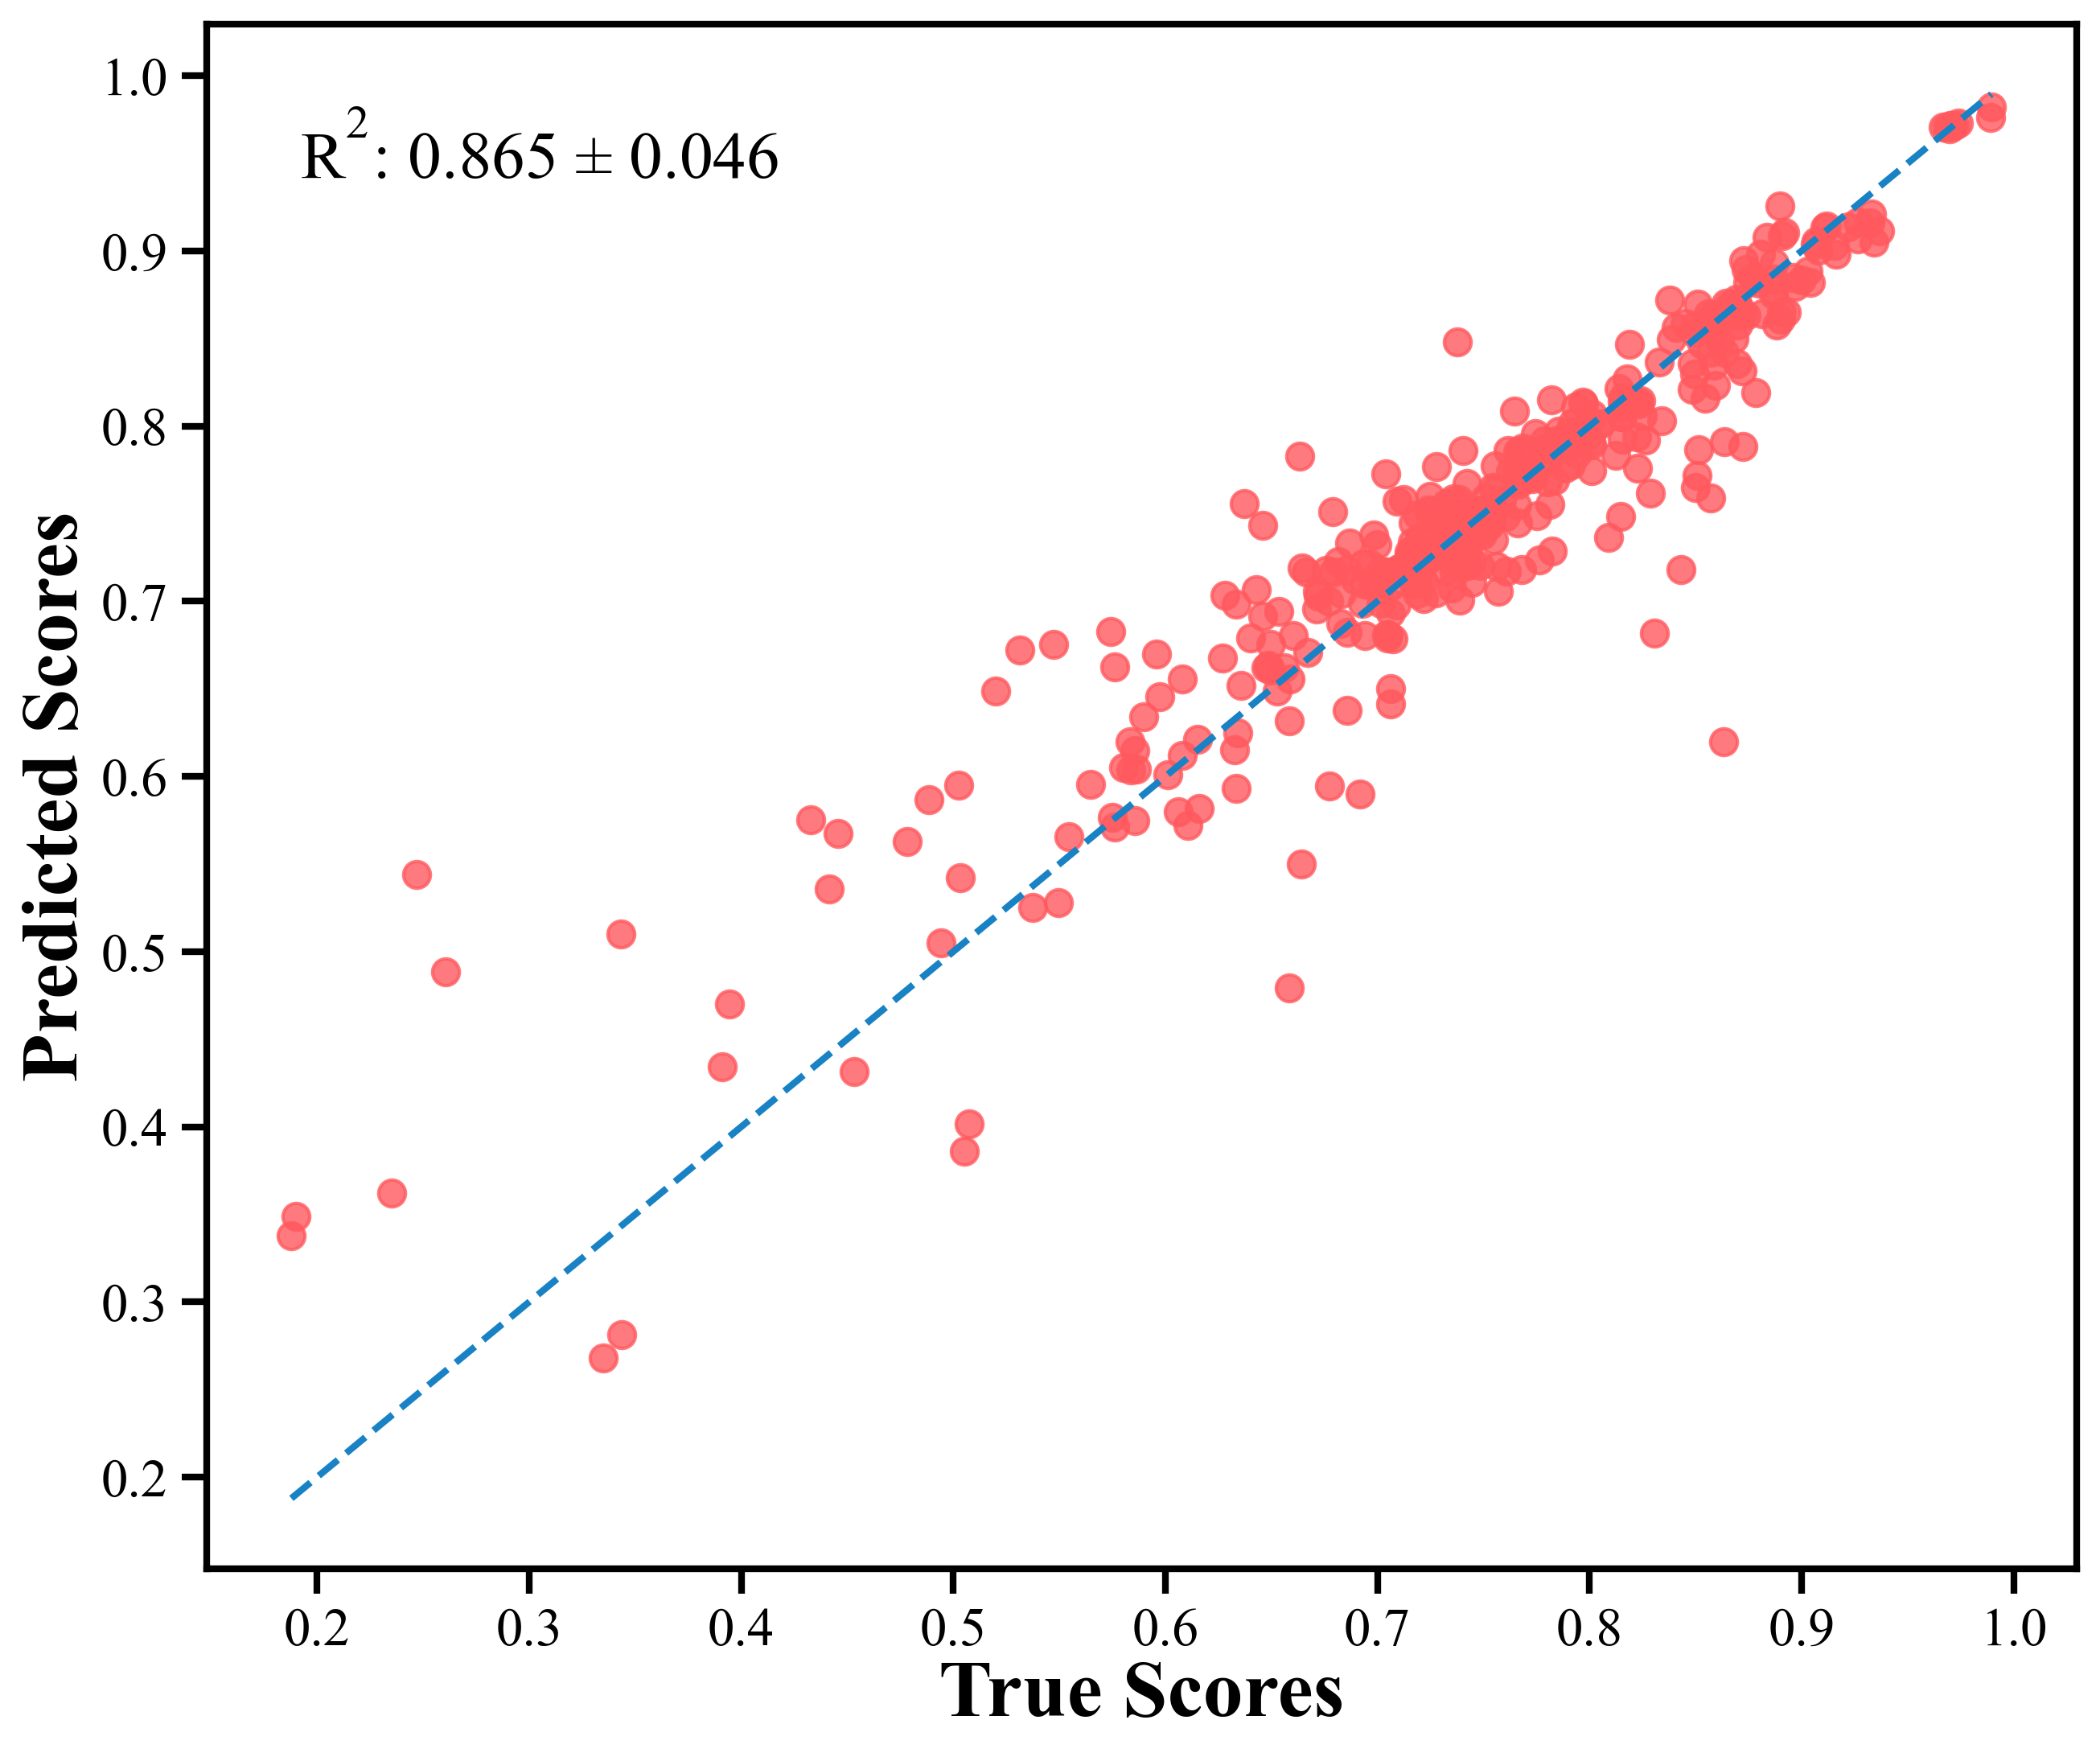

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def adjusted_r2_score(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

# ========== 数据处理 ==========
select_cols = ["scores"] + X_cols
exp_df = df[select_cols].copy()
categorical_cols = exp_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    exp_df[col] = le.fit_transform(exp_df[col].astype(str))

print("Used cols", exp_df.columns.tolist())

# ========== 模型与KFold ==========
model = RandomForestRegressor(n_estimators=500, random_state=42)
X = exp_df.drop(columns=["scores"])
print("Features used:", X.columns.tolist())
y = exp_df["scores"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_trues = []
all_preds = []
r2_scores = []
adjusted_r2_scores = []

# 保存SHAP数据
shap_values_all = []
X_all = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    all_trues.extend(y_test.tolist())
    all_preds.extend(preds.tolist())

    y_test = inv_boxcox(y_test, lambda_scores)
    preds = inv_boxcox(preds, lambda_scores)

    r2 = r2_score(y_test, preds)
    adjusted_r2 = adjusted_r2_score(y_test, preds, X_test.shape[1])
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2)

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap_values_all.append(shap_values)
    X_all.append(X_test)

# ========== 汇总结果 ==========
print(f"R2 Scores: {r2_scores}")
print(f"Adjusted R2 Scores: {adjusted_r2_scores}")

# 反变换预测值
print("Lambda used for inverse Box-Cox transformation:", lambda_scores)
all_preds = inv_boxcox(np.array(all_preds), lambda_scores)
all_trues = inv_boxcox(np.array(all_trues), lambda_scores)

# ========== R2 散点图 ==========
plt.figure(figsize=(10, 8))
plt.plot(
    [min(all_trues), max(all_trues)],
    [min(all_trues), max(all_trues)],
    color="#1982C4",
    linestyle="--",
)
plt.scatter(all_trues, all_preds, alpha=0.8)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.text(
    0.05,
    0.90,
    f"$R^2$: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}",
    transform=plt.gca().transAxes,
    fontsize=20,
)
plt.savefig("plots/scores_r2_scatter.png", dpi=300, bbox_inches="tight")
plt.show()


In [72]:
# save model
import pickle

pickle.dump(model, open("models/rf_model_scores.pkl", "wb"))

In [73]:
y

0     -0.092528
1     -0.115751
2     -0.095005
3     -0.108167
4     -0.120499
         ...   
380   -0.182754
381   -0.232723
382   -0.294623
383   -0.258310
384   -0.293702
Name: scores, Length: 385, dtype: float64

In [74]:
model.predict([X.iloc[1].tolist()])

d:\software\miniforge3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([-0.12209115])

In [75]:
model

RandomForestRegressor(n_estimators=500, random_state=42)

Default feature order: ['corr_max_js', 'corr_max_pearson', 'corr_max_dcor', 'dcc_dcor', 'dcc_pearson', 'dcc_js']


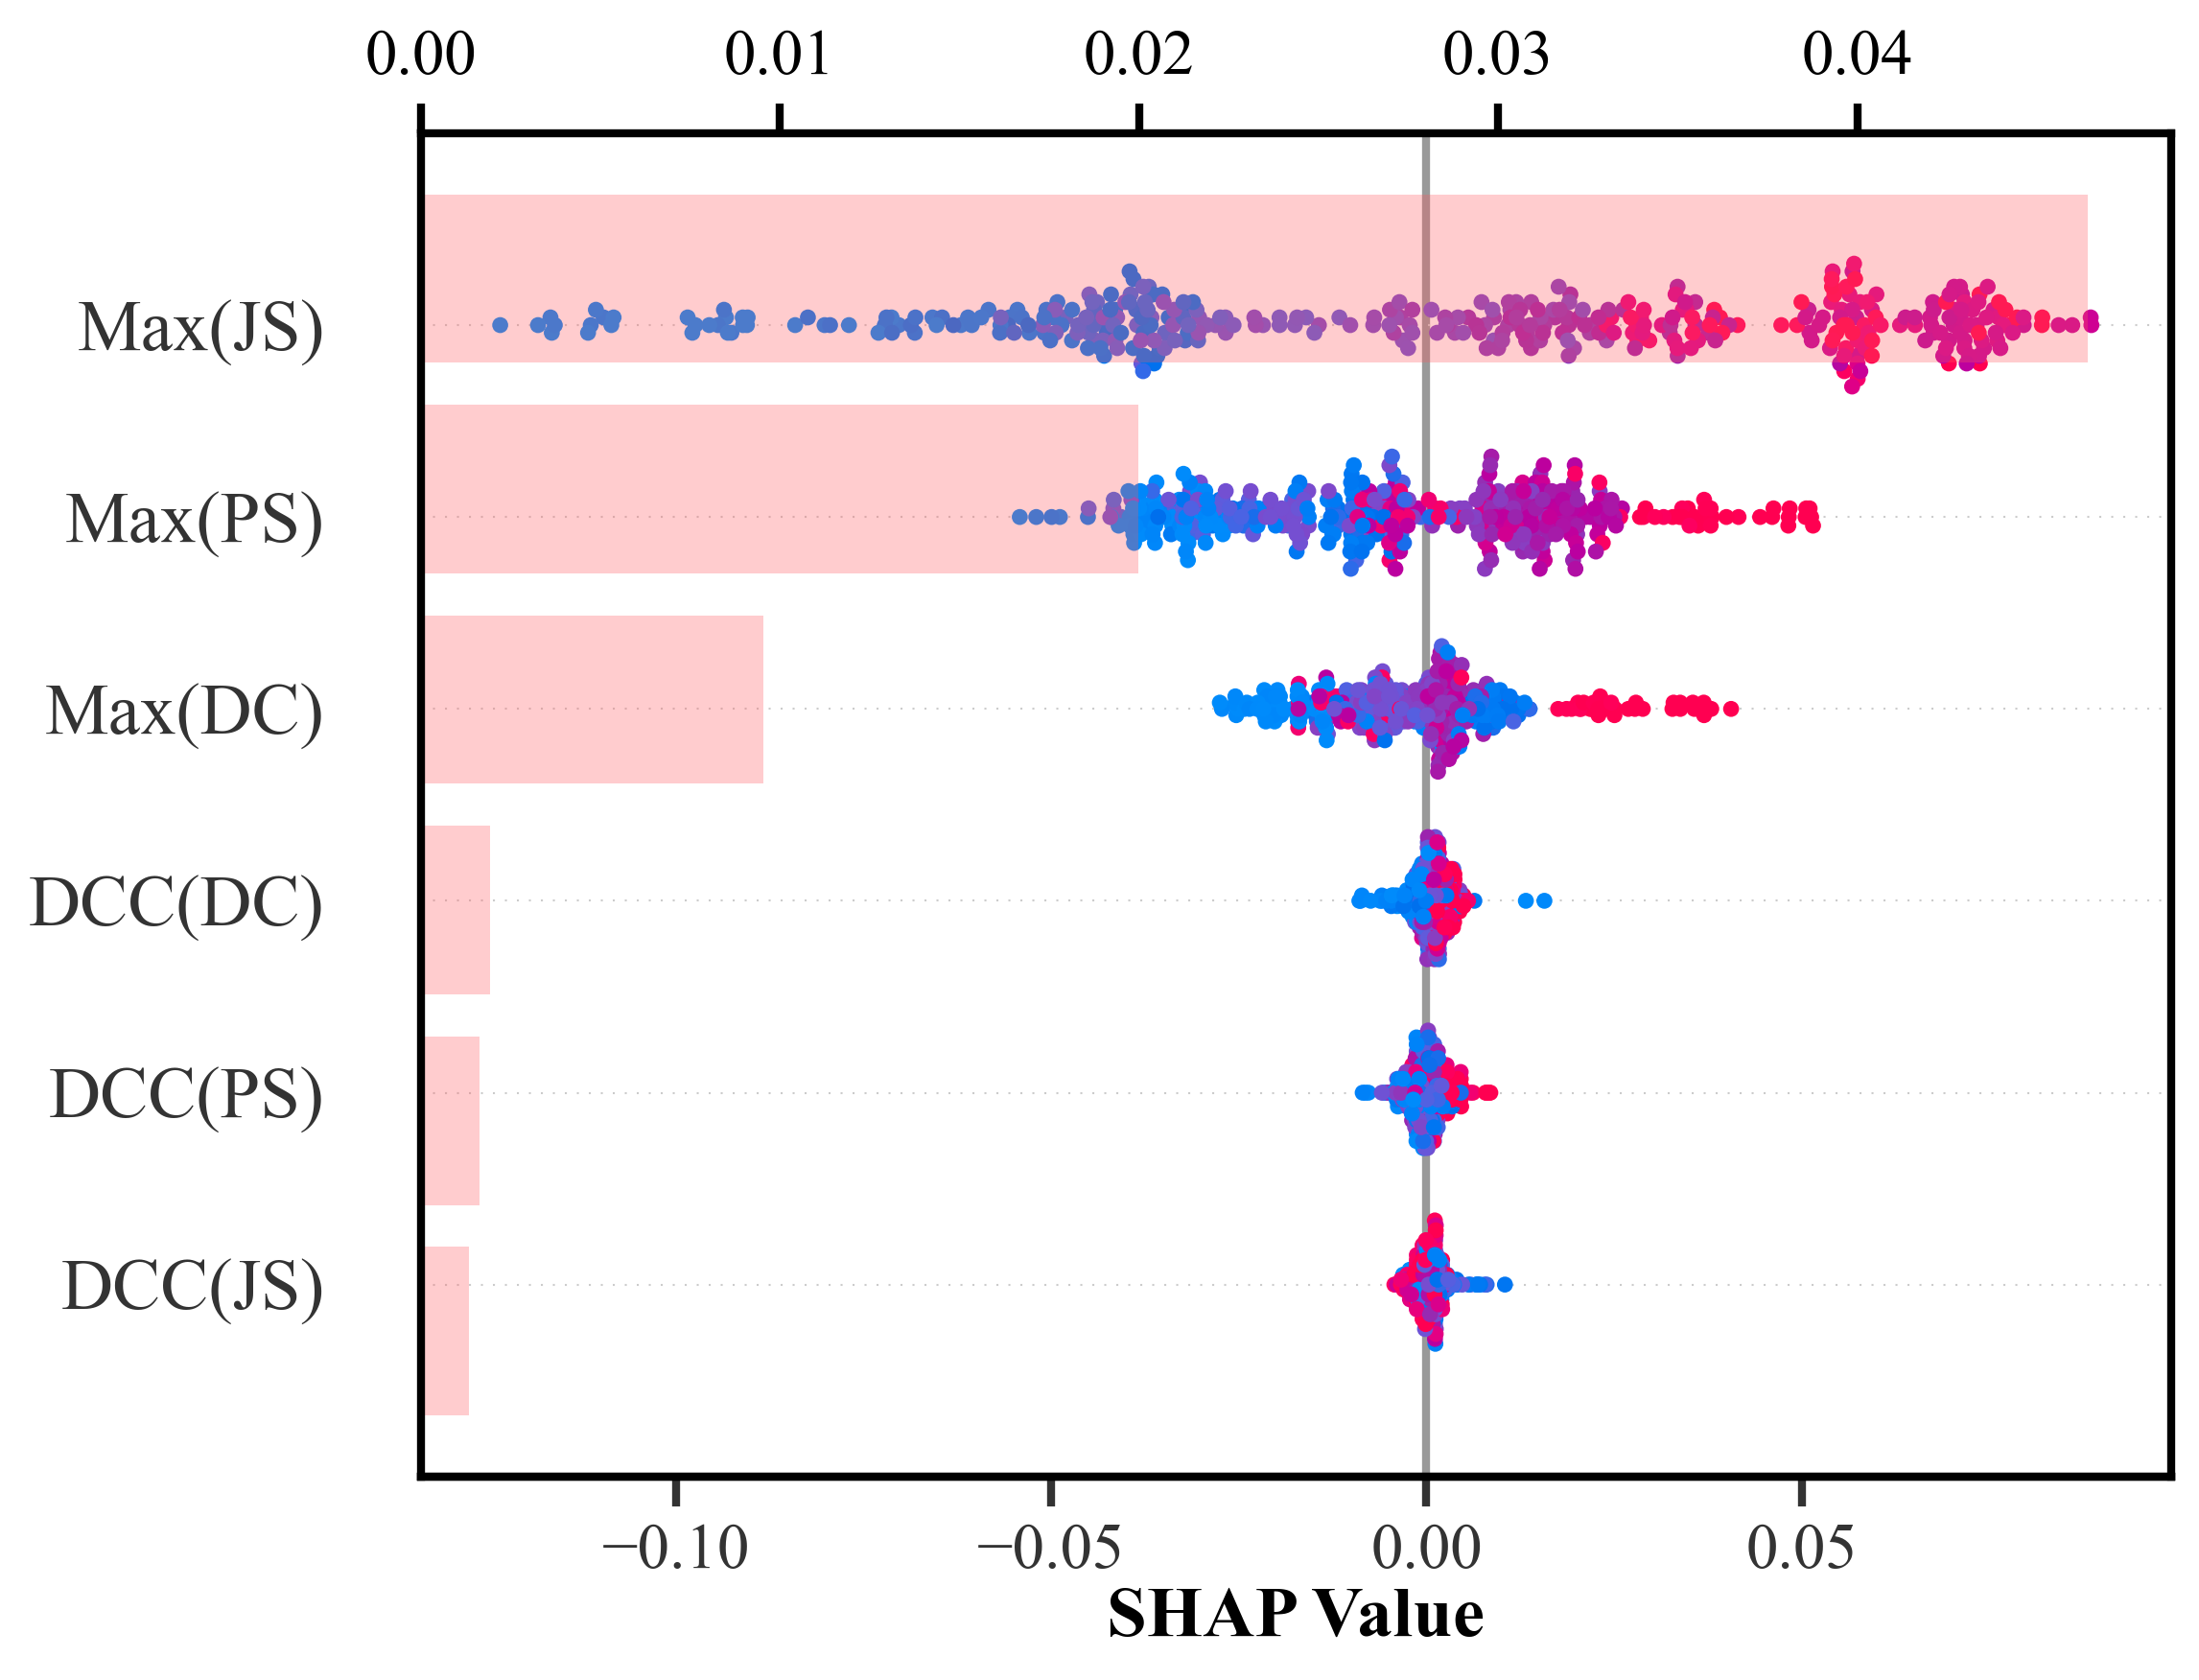

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ========== SHAP 合并画图 ==========
# 合并所有折的 SHAP 值和输入
shap_values_concat = np.concatenate(shap_values_all, axis=0)
X_concat = pd.concat(X_all, axis=0)

# 计算默认特征重要性顺序（用于排序）
mean_abs_shap = np.abs(shap_values_concat).mean(axis=0)
sort_idx = np.argsort(mean_abs_shap)[::-1]
feature_names = X_concat.columns[sort_idx].tolist()
print("Default feature order:", feature_names)

# 自定义名称（确保顺序一致）
custom_names = [custom_lables_dict.get(col, col) for col in feature_names]
custom_names = list(reversed(custom_names))  # 因为SHAP图从上到下是从小到大

# 创建画布
fig, ax1 = plt.subplots(figsize=(8, 6))

# ===== 绘制 SHAP 点图 =====
shap.summary_plot(
    shap_values_concat, 
    X_concat, 
    show=False, 
    max_display=len(custom_names), 
    feature_names=custom_names,
    color_bar=False,
)
plt.gca().tick_params(axis='x', labelsize=16)
plt.gca().set_xlabel("SHAP Value", fontsize=18)
plt.gca().set_yticklabels(custom_names, fontsize=18)
# ===== 绘制 SHAP 条形图 =====
ax2 = ax1.twiny()
bar_heights = mean_abs_shap[sort_idx][::-1]
ax2.barh(
    np.arange(len(feature_names)),
    bar_heights,
    alpha=0.3,
)

# 调整布局
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.savefig("plots/scores_shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()